<a href="https://colab.research.google.com/github/mhdSharuk/Data-Science-Bowl-2K19/blob/master/DSB_2019_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes

**PBS KIDS MEASURE UP APP**


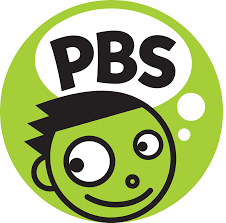



**1) Description of the all the columns**





*   **event_id** - Randomly generated unique identifier for the event type. Maps to event_id column in specs table.
*   **game_session** - Randomly generated unique identifier grouping events within a single game or video play session.
*   **timestamp** - Client-generated datetime
*   **event_data** - Semi-structured JSON formatted string containing the events parameters. Default fields are: event_count, event_code, and game_time; otherwise fields are determined by the event type.
*   **installation_id** - Randomly generated unique identifier grouping game sessions within a single installed application instance.
*   **event_count** - Incremental counter of events within a game session (offset at 1). Extracted from event_data.
*   **event_code** - Identifier of the event 'class'. Unique per game, but may be duplicated across games. E.g. event code '2000' always identifies the 'Start Game' event for all games. Extracted from event_data.
*   **game_time** - Time in milliseconds since the start of the game session. Extracted from event_data.
*   **title** - Title of the game or video.
*   **type** - Media type of the game or video. Possible values are: 'Game', 'Assessment', 'Activity', 'Clip'.
*   **world** - The section of the application the game or video belongs to. Helpful to identify the educational curriculum goals of the media. Possible values are: 'NONE' (at the app's start screen), TREETOPCITY' (Length/Height), 'MAGMAPEAK' (Capacity/Displacement), 'CRYSTALCAVES' (Weight).






**2) Groupby data to get the number of attempts each installation_id played**


*   train_data.groupby(['game_session','installation_id'],as_index =False)['title'].agg({'value_counts'}).rename(columns={'value_counts':'Total_no'}).head()

*   test_data.groupby(['game_session','installation_id'])['title'].agg({'value_counts'}).rename(columns={'value_counts':'Total_no'}).index.get_level_values(3)


**3) Event Codes Meaning**

*   2000 : Start of the game
*   3010 : Voice description of what to do in the game
*   3110 : Starting of game with the voice description in the background
*   4070 : Player starting to play the game


**4) Data Analysis**
* All Event Id has the same value for a particular game title event though they have different installation id
* All Event Code have same value for a particular Event Id

# Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Importing Required Modules

In [0]:
!pip install featexp

In [0]:
!pip install catboost

In [0]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)
import featexp 
import numpy as np
import os
import gc
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import json
import pprint
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier,CatBoostRegressor,Pool,cv
import xgboost as xgb
import lightgbm as lgb

# Helper Functions

In [0]:
def quadratic_weight_kappa(actual, prediction,n=4,hist_range=(0,3)):
  O = confusion_matrix((actual,prediction))
  O = np.divide(O,np.sum(O))

  W = np.zeros((n,n))
  for i in range(n):
    for j in range(n):
      W[i][j] = ((i-j)**2)/((n-1)**2)

  actual_histogram = np.histogram(actual,bins=n,range=hist_range)[0]
  prediction_histogram = np.histogram(prediction,bins=n,range=hist_range)[0]

  E = np.outer(actual_histogram,prediction_histogram)
  E = np.divide(E,np.sum(E))

  num = np.sum(np.multiply(W,O))
  density = np.sum(np.multiply(W,E))

  return 1 - np.divide(num,density)

In [0]:
def read_file():
  specs = pd.read_csv('/content/drive/My Drive/specs.csv')
  train_labels = pd.read_csv('./drive/My Drive/train_labels.csv.zip')
  train = pd.read_csv('./drive/My Drive/train.csv.zip')
  test = pd.read_csv('./drive/My Drive/test.csv.zip')
  sub = pd.read_csv('./drive/My Drive/sample_submission.csv')
  
  return specs,train_labels,train,test,sub

In [0]:
specs,train_labels,train,test,sub = read_file()

In [0]:
def prepare_data(df):

    df['attempt'] = 0
    df.loc[(df['title'] == 'Bird Measurer (Assessment)') & (df['event_code'] == 4110),
           'attempt'] = 1
    df.loc[(df['type'] == 'Assessment') &
           (df['title'] != 'Bird Measurer (Assessment)')
           & (df['event_code'] == 4100), 'attempt'] = 1

    df['correct'] = None
    df.loc[(df['attempt'] == 1) & (df['event_data'].str.contains('"correct":true')), 'correct'] = True
    df.loc[(df['attempt'] == 1) & (df['event_data'].str.contains('"correct":false')), 'correct'] = False

    df['success_attempt'] = df['correct'] * df['attempt']
    df['unsuccess_attempt'] = (df['correct'] == False) * df['attempt']

    df['world'] = df['world'].astype('category')
    df['type'] = df['type'].astype('category')
    if 'accuracy_group' in df.columns:
        df['accuracy_group_cat'] = df['accuracy_group'].astype('category')

    df['accuracy_calculated'] = df.groupby(['installation_id', 'game_session'])['success_attempt'].transform('sum') / \
                                df.groupby(['installation_id', 'game_session'])['attempt'].transform('sum')
    df['total_attempts'] = df.groupby(['installation_id', 'game_session'])['attempt'].transform('sum')
    return df

In [0]:
def get_datetime(df):
  df['timestamp'] = pd.to_datetime(df['timestamp'])
  df['date'] = df['timestamp'].dt.date
  df['month'] = df['timestamp'].dt.month
  df['hour'] = df['timestamp'].dt.hour
  df['minute'] = df['timestamp'].dt.minute
  df['day_of_week'] = df['timestamp'].dt.dayofweek
  
for c in [train,test]:
  get_datetime(c)
  c.pop('timestamp')

In [0]:
def gametime_to(df):
  df['game_time_seconds'] = df['game_time']/1000

gametime_to(train)
gametime_to(test)

# Exploratatry Data Analysis

In [0]:
event_map = {}
for eid,code in train[['event_id','event_code']].values:
  event_map[eid] = code

In [0]:
specs['event_code'] = specs['event_id'].map(event_map)
specs = specs[['event_id','event_code','info','args']]

In [14]:
specs.head()

,event_id,event_code,info,args
0,2b9272f4,3121.0,"The end of system-initiated feedback (Correct) event occurs when the game finishes delivering feedback to the player in response to a correct round attempt (pressing the go button with the correct answer). It contains information that describes the duration and content of the instruction, and will likely occur in conjunction with a beat round event. These events are used to determine the effectiveness of the feedback. We can answer questions like, ""how much time elapsed while the game was presenting feedback?""","[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""round"",""type"":""int"",""info"":""number of the current round when the event takes place or 0 if no round""},{""name"":""level"",""type"":""int"",""info"":""number of the current level when the event takes place or 0 if no level""},{""name"":""description"",""type"":""string"",""info"":""the text or description of the instruction""},{""name"":""identifier"",""type"":""string"",""info"":""a unique identifier for this piece of instruction""},{""name"":""media_type"",""type"":""string"",""info"":""the type of media that has just played:\n'audio' || 'animation' || 'other'""},{""name"":""duration"",""type"":""int"",""info"":""the duration of the media playback in milliseconds""},{""name"":""event_count"",""type"":""int"",""info"":""session event counter""},{""name"":""event_code"",""type"":""int"",""info"":""event class identifier""}]"
1,df4fe8b6,3120.0,"The end of system-initiated feedback (Incorrect) event occurs when the game finishes delivering feedback to the player in response to an incorrect round attempt (pressing the go button with the incorrect answer). It contains information that describes the content of the instruction. These events are used to determine the effectiveness of the feedback. We can answer questions like, ""how much time elapsed while the game was presenting feedback?""","[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""description"",""type"":""string"",""info"":""the text or description of the instruction""},{""name"":""identifier"",""type"":""string"",""info"":""a unique identifier for this piece of instruction""},{""name"":""media_type"",""type"":""string"",""info"":""the type of media that has just played:\n'audio' || 'animation' || 'other'""},{""name"":""duration"",""type"":""int"",""info"":""the duration of the media playback in milliseconds""},{""name"":""event_count"",""type"":""int"",""info"":""session event counter""},{""name"":""event_code"",""type"":""int"",""info"":""event class identifier""}]"
2,3babcb9b,3110.0,"The end of system-initiated instruction event occurs when the game finishes delivering instructions to the player. It contains information that describes the content of the instruction including duration. These events are used to determine the effectiveness of the instructions and the amount of time they consume. We can answer questions like, ""how much time elapsed while the game was presenting instruction?""","[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""round"",""type"":""int"",""info"":""number of the current round when the event takes place or 0 if no round""},{""name"":""description"",""type"":""string"",""info"":""the text or description of the instruction""},{""name"":""identifier"",""type"":""string"",""info"":""a unique identifier for this piece of instruction""},{""name"":""media_type"",""type"":""string"",""info"":""the type of media that has just played:\n'audio' || 'animation' || 'other'""},{""name"":""duration"",""type"":""int"",""info"":""the duration of the media playback in milliseconds""},{""name"":""event_count"",""type"":""int"",""info"":""session event counter""},{""name"":""event_code"",""type"":""int"",""info"":""event class identifier""}]"
3,7f0836bf,3110.0,"The end of system-ini

In [15]:
print(f'Number of rows : {train.shape[0]}, Number of columns : {train.shape[1]}')
print()
train.describe()

Number of rows : 11341042, Number of columns : 17



,event_count,event_code,game_time,month,hour,minute,day_of_week,game_time_seconds,game_time_minutes
count,1.134104e+07,1.134104e+07,1.134104e+07,1.134104e+07,1.134104e+07,1.134104e+07,1.134104e+07,1.134104e+07,1.134104e+07
mean,1.056642e+02,3.513838e+03,1.976236e+05,8.728246e+00,1.477273e+01,2.954236e+01,3.007176e+00,1.976236e+02,3.293726e+00
std,1.483477e+02,6.816470e+02,1.803968e+06,8.426431e-01,6.779303e+00,1.733948e+01,1.978353e+00,1.803968e+03,3.006613e+01
min,1.000000e+00,2.000000e+03,0.000000e+00,7.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.500000e+01,3.021000e+03,3.061800e+04,8.000000e+00,1.300000e+01,1.400000e+01,1.000000e+00,3.061800e+01,5.103000e-01
50%,6.100000e+01,4.020000e+03,7.276100e+04,9.000000e+00,1.600000e+01,2.900000e+01,3.000000e+00,7.276100e+01,1.212683e+00
75%,1.290000e+02,4.035000e+03,1.574460e+05,9.000000e+00,2.000000e+01,4.500000e+01,5.000000e+00,1.574460e+02,2.624100e+00
max,3.368000e+03,5.010000e+03,3.069102e+08,1.000000e+01,2.300000e+01,5.900000e+01,6.000000e+00,3.069102e+05,5.115171e+03


In [16]:
print(f'Number of rows : {train_labels.shape[0]}, Number of columns : {train_labels.shape[1]}')
print()
train_labels.describe()

Number of rows : 17690, Number of columns : 7



,num_correct,num_incorrect,accuracy,accuracy_group
count,17690.000000,17690.000000,17690.000000,17690.000000
mean,0.760938,1.587790,0.595810,1.885585
std,0.426523,3.058295,0.430559,1.256796
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.111111,1.000000
50%,1.000000,0.500000,0.750000,2.500000
75%,1.000000,2.000000,1.000000,3.000000
max,1.000000,85.000000,1.000000,3.000000


# Feature Engineering

In [0]:
le = LabelEncoder()

In [0]:
train = prepare_data(train)

In [0]:
train['accuracy_group'] = None
train.loc[(train['type'] == 'Assessment'), 'accuracy_group'] = 0
train.loc[(train['accuracy_calculated'] == 1) & (train['type'] == 'Assessment'), 'accuracy_group'] = 3
train.loc[(train['accuracy_calculated'] == 0.5) & (train['type'] == 'Assessment'), 'accuracy_group'] = 2
train.loc[(train['accuracy_calculated'] < 0.5) & (train['accuracy_calculated'] > 0) & (train['total_attempts'] > 0) & (train['type'] == 'Assessment'), 'accuracy_group'] = 1

In [0]:
test = prepare_data(test)

In [13]:
for df in tqdm_notebook([train,test]):
  for cols in ['game_session','timestamp','event_data']:
    df.pop(cols)

In [14]:
for df in tqdm_notebook([train,test]):
  for cols in ['title','type','world']:
    df[cols] = le.fit_transform(df[cols])

In [15]:
train.head()

,event_id,installation_id,event_count,event_code,game_time,title,type,world,attempt,correct,success_attempt,unsuccess_attempt,accuracy_calculated,total_attempts,accuracy_group
0,27253bdc,0001e90f,1,2000,0,43,2,2,0,None,NaN,0,NaN,0,None
1,27253bdc,0001e90f,1,2000,0,28,2,1,0,None,NaN,0,NaN,0,None
2,77261ab5,0001e90f,1,2000,0,35,0,1,0,None,NaN,0,NaN,0,None
3,b2dba42b,0001e90f,2,3010,53,35,0,1,0,None,NaN,0,NaN,0,None
4,1bb5fbdb,0001e90f,3,3110,6972,35,0,1,0,None,NaN,0,NaN,0,None


In [0]:
stats = featexp.get_trend_stats(data = train, target_col = 'accuracy_group')

In [0]:
stats